In [1]:
%load_ext autoreload
%autoreload 2

import math

import matplotlib.pyplot as plt
import numpy as np
import scipy.linalg
import torch
from torch import Tensor

# import my own code, which is under ae/pca/
from ae.pca.models import (
    compute_principal_axes,
    get_posterior_predictions_PCA,
    get_posterior_predictions_ST,
    initialize_model_PCA,
    initialize_model_ST,
)
from ae.pca.simulation import generate_principal_axes, PCATestProblem
from ae.pca.utils import compute_cosine_sim, loocv, plot_metric_loocv_results, plot_metric_posterior, scatter_plot_w_diag_line
from ae.pca.transforms import PCAOutcomeTransform


# import botorch, gpytorch functions
from botorch import fit_gpytorch_model
from botorch.optim.fit import fit_gpytorch_scipy
from botorch.optim.utils import _filter_kwargs
from botorch.utils.sampling import draw_sobol_samples
from botorch.models import SingleTaskGP
from botorch.models.transforms.outcome import ChainedOutcomeTransform, Standardize

from gpytorch.kernels import MaternKernel
from gpytorch.mlls import ExactMarginalLogLikelihood
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.priors import GammaPrior

I0106 065925.511 magics.py:79] %autoreload 2 was called with 


I0106 065926.152 _utils_internal.py:179] NCCL_DEBUG env var is set to None


I0106 065926.154 _utils_internal.py:197] NCCL_DEBUG is forced to WARN from None


# Overview

In this notebook, we generate synthetic metric data and test two modeling approaches, namely

- [baseline] fit a single-task GP to each metric
- [proposed] perform PCA on the metric data, and fit single-task GPs to the principal components (PCs)

## TL;DR: 
We use a toy example to show that using all the principal axes (same number as output space dimension) achieves a better model fit than fitting independent single-task GPs.

(Next steps would be to increase the dimensionality and use fewer principal axes.)

## 1. Generate synthetic data

As a toy example, we work with a one-dimensional input space [0, 1] and two-dimensional output space (i.e., metric space). We fix two ground-truth principal axes and generate scalar PC values from two single-task GPs with different lengthscales, so that the first principal axis is more dominant.

In [36]:
config = {
    "input_dim": 1,
    "outcome_dim": 2,
    "latent_dim": 2,
    "PC_noise_level": 0,
    "noise_std": 0.2,
    "num_initial_samples": 20,
    "num_sample_points": 30,
    "jitter": 0.00001,  # noqa
    "ground_truth_principal_axes": torch.Tensor([[0.707, 0.707], [-0.707, 0.707]]),
    "PC_lengthscales": [0.1, 0.5],
    "PC_scaling_factors": [2, 1],
    "variance_explained_threshold": 0.99,
}

tkwargs = {
    "dtype": torch.double,
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
}

In [37]:
torch.manual_seed(1234)

full_axes = generate_principal_axes(
    output_dim=config["outcome_dim"], num_axes=config["outcome_dim"], **tkwargs
)

ground_truth_principal_axes = full_axes[: config["latent_dim"]]
initial_X = torch.randn((config["num_initial_samples"], config["input_dim"]), **tkwargs)

obj_indices = list(range(config["outcome_dim"]))
cons_indices = []

problem = PCATestProblem(
    opt_config=(obj_indices, cons_indices),
    initial_X=initial_X,
    bounds=torch.Tensor([[0, 1]] * config["input_dim"]),
    ground_truth_principal_axes=ground_truth_principal_axes,
    noise_std=config["noise_std"],
    PC_lengthscales=Tensor(config["PC_lengthscales"]),
    PC_scaling_factors=Tensor(config["PC_scaling_factors"]),
    dtype=torch.double,
)

In [38]:
torch.manual_seed(123)

train_X = (
    draw_sobol_samples(bounds=problem.bounds, n=1, q=20)
    .squeeze(0)
    .to(torch.double)
)


train_Y = problem.eval_metrics_noisy(train_X).detach()
train_Y = train_Y - torch.mean(train_Y, dim = 0)

In [39]:
from typing import Optional, Tuple

from botorch.models.transforms.input import InputTransform, ReversibleInputTransform
from botorch.models.transforms.outcome import OutcomeTransform
from botorch.posteriors import Posterior, TransformedPosterior
from sklearn.decomposition import PCA
from torch import Tensor

# code credit to Sait
class ModifiedTransformedPosterior(TransformedPosterior):
    @property
    def event_shape(self) -> torch.Size:
        r"""The event shape (i.e. the shape of a single sample)."""
        return self.rsample().shape[-2:]

    def _extended_shape(
        self, sample_shape: torch.Size = torch.Size()  # noqa: B008
    ) -> torch.Size:
        r"""Returns the shape of the samples produced by the posterior with
        the given `sample_shape`.

        NOTE: This assumes that the `sample_transform` does not change the
        shape of the samples.
        """

        # print("self.rsample().shape", self.rsample().shape)
        # print("sample_shape", sample_shape)
        # return self._posterior._extended_shape(sample_shape=self.rsample().shape[-2:])
        return self.rsample().shape[-2:]

        # TODO: update difff


# referred to Wesley's private PCA-GP code
class PCAOutcomeTransform(OutcomeTransform):
    def __init__(
        self,
        variance_explained_threshold: float = 0.9,
        num_axes: Optional[int] = None,
        *tkwargs,
    ):
        r"""
        Initialize PCAOutcomeTransform() instance
        Args:
            variance_explained_threshold: fraction of variance in the data that we want the selected principal axes to explain;
                if num_axes is None, use this to decide the number of principal axes to select
            num_axes: number of principal axes to select
        """

        super().__init__()
        self.variance_explained_threshold = variance_explained_threshold
        self.num_axes = num_axes

    def forward(
        self, Y: torch.Tensor, Yvar: Optional[torch.Tensor] = None, **tkwargs
    ) -> Tuple[torch.Tensor, Optional[torch.Tensor]]:
        r"""
        Perform PCA on data Y and transforms it to a lower-dimensional representation in terms of principal components.
        Args:
            Y: `batch_shape x num_samples x output_dim` tensor of metric observations;
                assume that it is centered already, since we would normally chain the PCAOutcomeTransform() after a Standardize()
            Yvar: (optional) `batch_shape x num_samples x output_dim` tensor of metric noises (variance)
        Returns:
            Y_transformed: `batch_shape x num_samples x PC_dim` tensor of PC values
            Yvar_transformed: `batch_shape x num_samples x PC_dim` tensor of estimated PC variances
        """

        if self.training:

            # TODO: use pytorch's SVD rather than sklearn to perform PCA
            # Reason: axes_learned depends on the training targets (Y);
            # any quantity that depends on the posterior in the metrics space will have its gradient
            # d f(metric posterior)
            # dependent on d (axes_learned) / d (training targets)
            # but this step is done in sklearn, so torch gradient computation can't propagate through
            # (we can of course use the sklearn results to check correctness)

            pca = PCA()
            _ = pca.fit_transform(Y)
            explained_variance = pca.explained_variance_ratio_

            if self.num_axes is None:
                # decide the number of principal axes to keep (that makes explained variance exceed the specified threshold)
                exceed_thres = (
                    np.cumsum(explained_variance) > self.variance_explained_threshold
                )
                self.num_axes = len(exceed_thres) - sum(exceed_thres) + 1

            axes_learned = pca.components_[: self.num_axes, :]
            self.PCA_explained_variance = sum(explained_variance[: self.num_axes])
            self.axes_learned = torch.tensor(axes_learned, **tkwargs)

        Y_transformed = torch.matmul(Y, torch.transpose(self.axes_learned, -2, -1)).to(
            **tkwargs
        )

        # if Yvar is given, the variance of PCs is lower bounded by the linear combination of Yvar terms
        # technically, the variance of PCs should include the covariance between Y's, but that is usually not available
        if Yvar is not None:
            Yvar_transformed = torch.matmul(
                Yvar, torch.square(torch.transpose(self.axes_learned, -2, -1))
            ).to(**tkwargs)

        return Y_transformed, Yvar_transformed if Yvar is not None else None

    def untransform(
        self, Y: torch.Tensor, Yvar: Optional[torch.Tensor] = None, **tkwargs
    ) -> Tuple[torch.Tensor, Optional[torch.Tensor]]:
        r"""
        Transform PC back to metrics according to self.axes_learned.
        Args:
            Y: `num_samples x PC_dim` tensor of PC values
            Yvar: `num_samples x PC_dim` tensor of PC variances
        Returns:
            Y_untransformed: `num_samples x output_dim` tensor of metric values
            Yvar_untransformed: `num_samples x output_dim` tensor of metric variances
        """

        Y_untransformed = torch.matmul(Y, self.axes_learned)
        if Yvar is not None:
            Yvar_untransformed = torch.matmul(Yvar, torch.square(self.axes_learned))

        return (
            Y_untransformed,
            Yvar_untransformed if Yvar is not None else None,
        )

    def untransform_posterior(self, posterior: Posterior):
        r"""
        Create posterior distribution in the space of metrics.
        Args:
            posterior: posterior in the space of PCs
        Returns:
            untransformed_posterior: posterior in the space of metrics
        """

        untransformed_posterior = ModifiedTransformedPosterior(
            posterior=posterior,
            sample_transform=lambda x: x.matmul(self.axes_learned),
            mean_transform=lambda x, v: x.matmul(self.axes_learned),
            variance_transform=lambda x, v: v.matmul(torch.square(self.axes_learned)),
        )
        # print("event shape", untransformed_posterior.event_shape)
        # print("extended shape", untransformed_posterior._extended_shape())

        return untransformed_posterior

In [40]:
st_model = SingleTaskGP(
    train_X,
    train_Y,
    covar_module = MaternKernel(lengthscale_prior = GammaPrior(3,6))
)
st_mll = ExactMarginalLogLikelihood(st_model.likelihood, st_model)
fit_gpytorch_model(st_mll)

ExactMarginalLogLikelihood(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (noise_prior): GammaPrior()
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (model): SingleTaskGP(
    (likelihood): GaussianLikelihood(
      (noise_covar): HomoskedasticNoise(
        (noise_prior): GammaPrior()
        (raw_noise_constraint): GreaterThan(1.000E-04)
      )
    )
    (mean_module): ConstantMean()
    (covar_module): MaternKernel(
      (lengthscale_prior): GammaPrior()
      (raw_lengthscale_constraint): Positive()
    )
  )
)

In [41]:
options = {"maxiter": 1000}

pca_model = SingleTaskGP(
    train_X,
    train_Y,
    outcome_transform=ChainedOutcomeTransform(
        **{
            "standardize": Standardize(2, min_stdv=10),
            "pca": PCAOutcomeTransform(num_axes=1),
        }
    ),
    # outcome_transform = PCAOutcomeTransform(),
    likelihood=GaussianLikelihood(noise_prior=GammaPrior(0.9, 10)),
)
pca_mll = ExactMarginalLogLikelihood(pca_model.likelihood, pca_model)

# train PCA model and log training stats
# fit_gpytorch_scipy(pca_mll, options=options)
fit_gpytorch_model(pca_mll)

ExactMarginalLogLikelihood(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (noise_prior): GammaPrior()
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (model): SingleTaskGP(
    (likelihood): GaussianLikelihood(
      (noise_covar): HomoskedasticNoise(
        (noise_prior): GammaPrior()
        (raw_noise_constraint): GreaterThan(1.000E-04)
      )
    )
    (mean_module): ConstantMean()
    (covar_module): ScaleKernel(
      (base_kernel): MaternKernel(
        (lengthscale_prior): GammaPrior()
        (raw_lengthscale_constraint): Positive()
      )
      (outputscale_prior): GammaPrior()
      (raw_outputscale_constraint): Positive()
    )
    (outcome_transform): ChainedOutcomeTransform(
      (standardize): Standardize()
      (pca): PCAOutcomeTransform()
    )
  )
)

In [42]:
axes_learned_tensor = pca_model.outcome_transform['pca'].axes_learned
# axes_learned_tensor = pca_model.outcome_transform.axes_learned
axes_learned_tensor

tensor([[0.5697, 0.8218]], dtype=torch.float64)

In [43]:
axes_learned = axes_learned_tensor.detach().numpy()

In [44]:
pca_model.outcome_transform["pca"].__dict__

{'training': False,
 '_parameters': OrderedDict(),
 '_buffers': OrderedDict(),
 '_non_persistent_buffers_set': set(),
 '_backward_pre_hooks': OrderedDict(),
 '_backward_hooks': OrderedDict(),
 '_is_full_backward_hook': None,
 '_forward_hooks': OrderedDict(),
 '_forward_hooks_with_kwargs': OrderedDict(),
 '_forward_pre_hooks': OrderedDict(),
 '_forward_pre_hooks_with_kwargs': OrderedDict(),
 '_state_dict_hooks': OrderedDict(),
 '_state_dict_pre_hooks': OrderedDict(),
 '_load_state_dict_pre_hooks': OrderedDict(),
 '_load_state_dict_post_hooks': OrderedDict(),
 '_modules': OrderedDict(),
 'variance_explained_threshold': 0.9,
 'num_axes': 1,
 'PCA_explained_variance': 0.9656020771495839,
 'axes_learned': tensor([[0.5697, 0.8218]], dtype=torch.float64)}

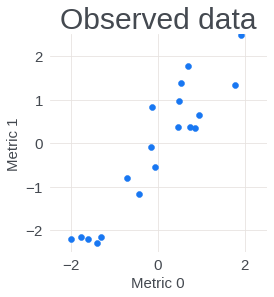

In [45]:
# plot the observed metric data, the ground truth principal axes, and the learned principal axes

plt.scatter(train_Y.numpy()[:, 0], train_Y.numpy()[:, 1])
plt.title("Observed data")
plt.xlabel("Metric 0")
plt.ylabel("Metric 1")
plt.xlim([-2.5, 2.5])
plt.ylim([-2.5, 2.5])
plt.gca().set_aspect("equal")

# axes = kwargs["ground_truth_principal_axes"]


# true_axis_0 = plt.arrow(x=0, y=0, dx=2 * axes_learned[0, 0], dy=2 * axes[0, 1], width=0.1, color="blue")
# true_axis_1 = plt.arrow(x=0, y=0, dx=axes[1, 0] / 5, dy=axes[1, 1] / 5, width=0.02, color="blue")

# learned_axis_0 = plt.arrow(x=0, y=0, dx=2 * axes_learned[0, 0], dy=2 * axes_learned[0, 1], width=0.1, color="orange")
# learned_axis_1 = plt.arrow(x=0, y=0, dx=axes_learned[1, 0] / 5, dy=axes_learned[1, 1] / 5, width=0.02, color="orange")

# plt.legend([true_axis_0, learned_axis_0], ["true axis", "learned axis"])
# plt.savefig("2Dexample.png", dpi=1200, bbox_inches='tight')

plt.savefig('WPnote_2Dproblem_PCAplot_noaxis.png')

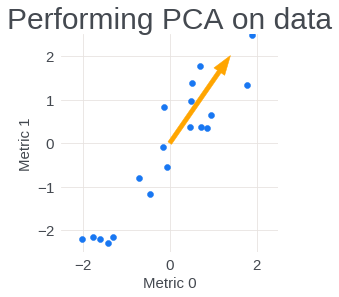

In [46]:
# plot the observed metric data, the ground truth principal axes, and the learned principal axes

plt.scatter(train_Y.numpy()[:, 0], train_Y.numpy()[:, 1])
plt.title("Performing PCA on data")
plt.xlabel("Metric 0")
plt.ylabel("Metric 1")
plt.xlim([-2.5, 2.5])
plt.ylim([-2.5, 2.5])
plt.gca().set_aspect("equal")

# axes = kwargs["ground_truth_principal_axes"]


# true_axis_0 = plt.arrow(x=0, y=0, dx=2 * axes_learned[0, 0], dy=2 * axes[0, 1], width=0.1, color="blue")
# true_axis_1 = plt.arrow(x=0, y=0, dx=axes[1, 0] / 5, dy=axes[1, 1] / 5, width=0.02, color="blue")

learned_axis_0 = plt.arrow(x=0, y=0, dx=2 * axes_learned[0, 0], dy=2 * axes_learned[0, 1], width=0.1, color="orange")
# learned_axis_1 = plt.arrow(x=0, y=0, dx=axes_learned[1, 0] / 5, dy=axes_learned[1, 1] / 5, width=0.02, color="orange")

# plt.legend([true_axis_0, learned_axis_0], ["true axis", "learned axis"])
# plt.savefig("2Dexample.png", dpi=1200, bbox_inches='tight')

plt.savefig('WPnote_2Dproblem_PCAplot.png')

In [47]:
PC_learned = torch.matmul(train_Y, torch.transpose(axes_learned_tensor, 0, 1))

In [48]:
model_pc = SingleTaskGP(
    train_X, PC_learned,
    # covar_module = MaternKernel(lengthscale_prior = GammaPrior(3,6))
    )
pc_mll = ExactMarginalLogLikelihood(pca_model.likelihood, model_pc)

fit_gpytorch_model(pc_mll)

ExactMarginalLogLikelihood(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (noise_prior): GammaPrior()
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (model): SingleTaskGP(
    (likelihood): GaussianLikelihood(
      (noise_covar): HomoskedasticNoise(
        (noise_prior): GammaPrior()
        (raw_noise_constraint): GreaterThan(1.000E-04)
      )
    )
    (mean_module): ConstantMean()
    (covar_module): ScaleKernel(
      (base_kernel): MaternKernel(
        (lengthscale_prior): GammaPrior()
        (raw_lengthscale_constraint): Positive()
      )
      (outputscale_prior): GammaPrior()
      (raw_outputscale_constraint): Positive()
    )
  )
)

torch.Size([101]) torch.Size([101])


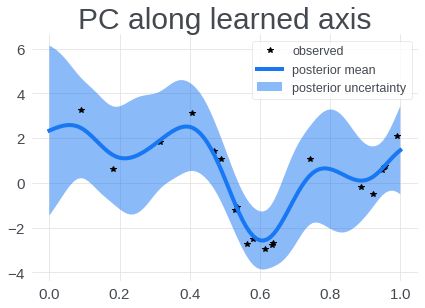

In [49]:
plt.plot(
    train_X.detach().numpy(), PC_learned.detach().numpy()[:, 0], "k*", label="observed"
)

plt.tight_layout()
plt.title("PC along learned axis")

num_test_points = 101
test_X = torch.linspace(0, 1, num_test_points).unsqueeze(1).to(**tkwargs)
test_PC_posterior_mean = model_pc.posterior(test_X).mean.squeeze(1)
test_PC_posterior_var = model_pc.posterior(test_X).variance.squeeze(1)
print(test_PC_posterior_mean.shape, test_PC_posterior_var.shape)
lower = test_PC_posterior_mean - 1.96 * torch.sqrt(test_PC_posterior_var)
upper = test_PC_posterior_mean + 1.96 * torch.sqrt(test_PC_posterior_var)

plt.fill_between(
    test_X.squeeze(1),
    lower.detach().numpy(),
    upper.detach().numpy(),
    alpha=0.5,
    label="posterior uncertainty",
)

plt.plot(test_X, test_PC_posterior_mean.detach().numpy(), label="posterior mean")

plt.legend(fontsize=12.5)

plt.savefig('WPnote_2Dproblem_GPonPC.png', bbox_inches='tight')

In [53]:
def plotting_helper(num_test_points, model, outcome_idxs, model_name):

    f, axs = plt.subplots(1, len(outcome_idxs), figsize = (12,4))

    test_X = torch.linspace(0, 1, num_test_points).unsqueeze(1).to(**tkwargs)

    test_Y = problem.eval_metrics_true(test_X).detach()

    # test_Y = problem.evaluate_true(test_X).detach()[:, outcome_idx]
    # plt.scatter(test_X, test_Y)

    for outcome_idx in outcome_idxs:

        axs[outcome_idx].plot(train_X, train_Y[:, outcome_idx].detach().numpy(), 'k*', label = 'observed')

        test_Y_posterior_mean = model.posterior(test_X).mean[:, outcome_idx]
        test_Y_posterior_var = model.posterior(test_X).variance[:, outcome_idx]
        lower = test_Y_posterior_mean - 1.96 * torch.sqrt(test_Y_posterior_var)
        upper = test_Y_posterior_mean + 1.96 * torch.sqrt(test_Y_posterior_var)

        axs[outcome_idx].fill_between(
            test_X.squeeze(1),
            lower.detach().numpy(),
            upper.detach().numpy(),
            alpha=0.5,
            label = 'posterior uncertainty'
        )

        axs[outcome_idx].set_title(f"{model_name} fitted outcome {outcome_idx}")

        axs[outcome_idx].plot(test_X, test_Y_posterior_mean.detach().numpy(), label = 'posterior mean')

        print('outcome', outcome_idx, 'RMSE', torch.sqrt(torch.mean(torch.square(test_Y_posterior_mean - test_Y[:,outcome_idx]))))

        axs[outcome_idx].legend(fontsize = 12.5)

outcome 0 RMSE tensor(1.1531, dtype=torch.float64, grad_fn=<SqrtBackward0>)
outcome 1 RMSE tensor(1.5596, dtype=torch.float64, grad_fn=<SqrtBackward0>)


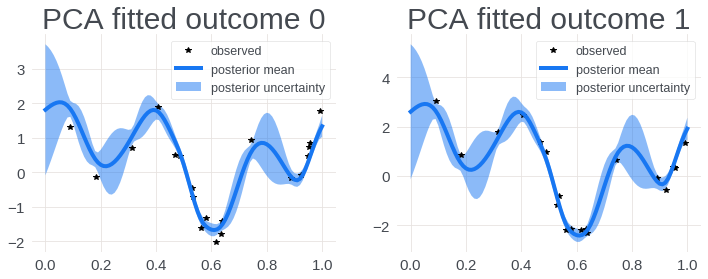

In [54]:
plotting_helper(101, pca_model,[0,1], "PCA")
# plt.title('PCA fitted outcome 0')
# plt.savefig('WPnote_2Dproblem_PCA.png')

outcome 0 RMSE tensor(1.0088, dtype=torch.float64, grad_fn=<SqrtBackward0>)
outcome 1 RMSE tensor(1.5695, dtype=torch.float64, grad_fn=<SqrtBackward0>)


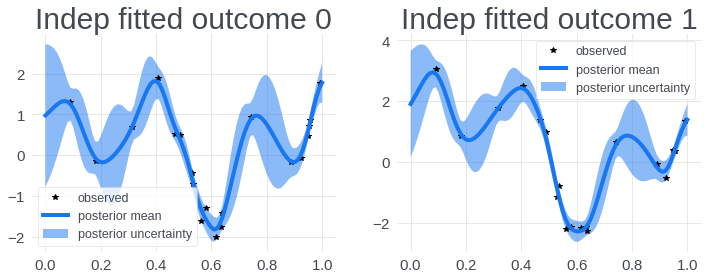

In [55]:
plotting_helper(101, st_model,[0, 1], "Indep")
# plt.savefig('WPnote_2Dproblem_Indep.png')

In [343]:
# next: 

# Below is old

## 2.1: Modeling fitting with PCA + GP

We perform PCA on the data and learn two principal axes. We project the observed metric data onto these axes and obtain data on PCs. Then we fit single-task GPs on these PCs (we use SingleTaskGP() rather than FixedNoiseGP() because typically the noise of PCs is hard to obtain in reality). 

Text(0.5, 1.0, 'Posterior PC means (PCA, inferring noise)')

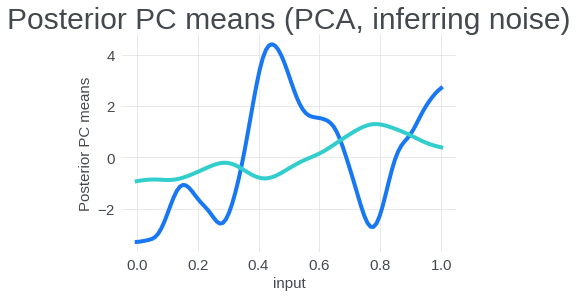

In [35]:
# Run PCA and have the model infer the noise of PCs

model_PCA, axes_learned = initialize_model_PCA(
    train_X=arms,
    train_Y=metric_observations,
    variance_explained_threshold=kwargs["variance_explained_threshold"],
)

mll_PCA_infer_noise = ExactMarginalLogLikelihood(model_PCA.likelihood, model_PCA)
fit_gpytorch_model(mll_PCA_infer_noise)
predicted_means_test = model_PCA.posterior(torch.linspace(0, 1, 100).unsqueeze(1)).mean


plt.plot(np.linspace(0, 1, 100), predicted_means_test.detach().numpy())
plt.xlabel("input")
plt.ylabel("Posterior PC means")
plt.title("Posterior PC means (PCA, inferring noise)")

In [54]:
# get posterior mean and variance of the metrics

(
    PC_posterior_mean_PCA,
    PC_posterior_variance_PCA,
    metric_posterior_mean_PCA,
    metric_posterior_variance_PCA,
) = get_posterior_predictions_PCA(arms, model_PCA, axes_learned, **tkwargs)

In [94]:
(
    PC_posterior_mean_PCA_test,
    PC_posterior_variance_PCA_test,
    metric_posterior_mean_PCA_test,
    metric_posterior_variance_PCA_test,
) = get_posterior_predictions_PCA(torch.linspace(0,1,100).unsqueeze(1), model_PCA, axes_learned, **tkwargs)

In [118]:
PC_learned = torch.matmul(metric_observations, torch.transpose(axes_learned, 0, 1))


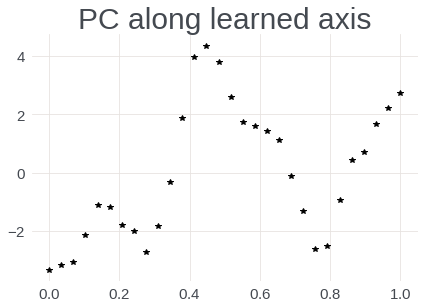

In [122]:
plt.plot(arms.detach().numpy(), PC_learned.detach().numpy()[:,0], 'k*')

plt.tight_layout()
plt.title("PC along learned axis")

plt.savefig("2Dexample_PC_learned.png", dpi=1200, bbox_inches='tight')


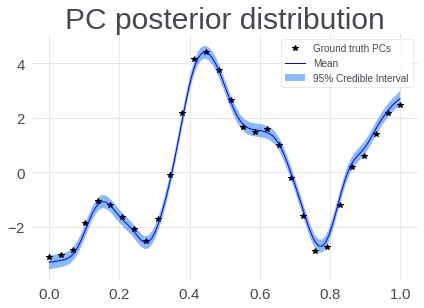

In [125]:
lower = PC_posterior_mean_PCA_test - 1.96 * torch.sqrt(PC_posterior_variance_PCA_test)
upper = PC_posterior_mean_PCA_test + 1.96 * torch.sqrt(PC_posterior_variance_PCA_test)

plt.plot(arms.detach().numpy(), ground_truth_PCs.detach().numpy()[:,0], 'k*')

plt.plot(np.linspace(0,1,100), PC_posterior_mean_PCA_test.detach().numpy()[:,0], "b", linewidth = 1)

plt.fill_between(
    np.linspace(0,1,100),
    lower.detach().numpy()[:, 0],
    upper.detach().numpy()[:, 0],
    alpha=0.5,
)
plt.legend(["Ground truth PCs", "Mean", "95% Credible Interval"])
plt.tight_layout()
plt.title("PC posterior distribution")

plt.savefig("2Dexample_PC_posterior.png", dpi=1200, bbox_inches='tight')


mean squared error = 0.004456156774257616


Text(0.5, 1.0, 'In-sample fit on metric 0 (PCA, inferring noise)')

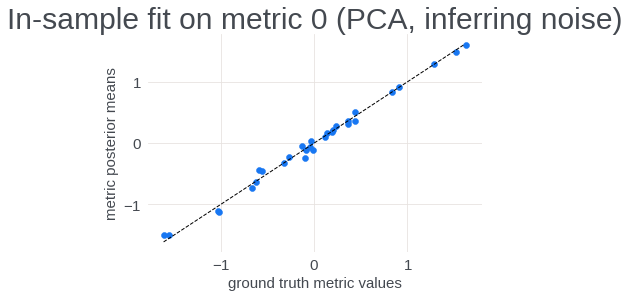

In [26]:
# check in-sample metric fit

check_dim = 0

scatter_plot_w_diag_line(metric_observations.detach().numpy(), metric_posterior_mean_PCA.detach().numpy(), check_dim)
plt.xlabel("ground truth metric values")
plt.ylabel("metric posterior means")
plt.title("In-sample fit on metric {} (PCA, inferring noise)".format(check_dim))

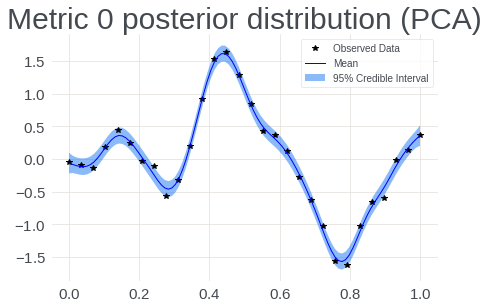

In [27]:
# plot posterior distribution on the metrics

plot_metric_posterior(
    test_x=torch.linspace(0, 1, 100),
    metric_dim=0,
    method="PCA",
    model=model_PCA,
    train_X=arms,
    train_Y=metric_observations,
    axes=axes_learned,
    **tkwargs
)

Full input data shape torch.Size([30, 1]), output data shape torch.Size([30, 2])
loocv round 0


loocv round 5


loocv round 10


loocv round 15


loocv round 20


loocv round 25


mean squared error = 0.021047954848982243


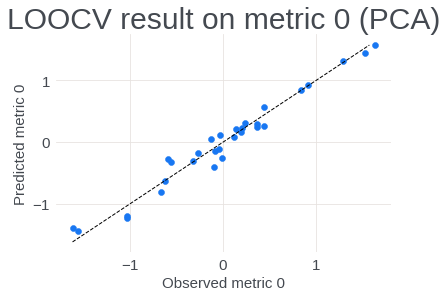

In [28]:
# perform leave-one-out cross validation 

plot_metric_loocv(
    X_all=arms, Y_all=metric_observations, method="PCA", metric_dim=0, variance_explained_threshold=0.9, **tkwargs
)

In [166]:
def plot_metric_loocv(
    X_all: torch.Tensor,
    Y_all: torch.Tensor,
    method: str,
    metric_dim: int,
    Y_var_all: torch.Tensor or float = None,
    variance_explained_threshold: float = None,
    **tkwargs,
):
    r"""
    Plot leave-one-out cross validation for a given dataset of inputs and observations and a specified method.

    Args:
        X_all: `num_samples x input_dim` tensor
        Y_all: `num_samples x output_dim` tensor
        method: one of {"PCA", "ST"}
        metric_dim: integer specifying the index of the metric we want to plot
        Y_var_all: either `num_samples x output_dim` tensor or float # TODO: only been using float now
        variance_explained_threshold: number between 0 and 1 specifying the amount of variance in the data
            that we want the principal axes to explain

    Returns:
        Plot of leave-one-out cross validation results for the `metric_dim`-th metric
    """

    posterior_mean_tmp, posterior_var_tmp = loocv(
        X_all=X_all,
        Y_all=Y_all,
        method=method,
        Y_var_all=Y_var_all,
        variance_explained_threshold=variance_explained_threshold,
        **tkwargs,
    )

    scatter_plot_w_diag_line(Y_all.detach().numpy(), posterior_mean_tmp.detach().numpy(), metric_dim)
    plt.xlabel("Observed metric {}".format(metric_dim))
    plt.ylabel("Predicted metric {}".format(metric_dim))
    plt.title("LOOCV result on metric {} ({})".format(metric_dim, method))

    # error bars along the y-axis, i.e., posterior standard deviation
    plt.errorbar(
        Y_all.detach().numpy()[:, metric_dim],
        posterior_mean_tmp.detach().numpy()[:, metric_dim],
        yerr=2 * torch.sqrt(posterior_var_tmp)[:, metric_dim],
        ls="none",
        linewidth=0.5,
    )

    # error bars along the x-axis, i.e., data noise
    if Y_var_all is not None:
        if torch.is_tensor(Y_var_all):
            plt.errorbar(
                Y_all.detach().numpy()[:, metric_dim],
                posterior_mean_tmp.detach().numpy()[:, metric_dim],
                xerr=2 * torch.sqrt(Y_var_all).detach().numpy()[:, metric_dim],
                ls="none",
                linewidth=0.5,
            )
        else:
            plt.errorbar(
                Y_all.detach().numpy()[:, metric_dim],
                posterior_mean_tmp.detach().numpy()[:, metric_dim],
                xerr=2 * Y_var_all,
                ls="none",
                linewidth=0.5,
            )

[autoreload of configerator.py_sidecar.shadow_client.configerator_sidecar_config failed: Traceback (most recent call last):
  File "/data/users/yujiazhang/fbsource/fbcode/buck-out/dev/gen/aab7ed39/ae/pca/bento_kernel_pca_gp#link-tree/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/data/users/yujiazhang/fbsource/fbcode/buck-out/dev/gen/aab7ed39/ae/pca/bento_kernel_pca_gp#link-tree/bento/lib/kernel_main.py", line 95, in new_superreload
    return old_superreload(module, importlib.reload, old_objects)
  File "/data/users/yujiazhang/fbsource/fbcode/buck-out/dev/gen/aab7ed39/ae/pca/bento_kernel_pca_gp#link-tree/IPython/extensions/autoreload.py", line 410, in superreload
    update_generic(old_obj, new_obj)
  File "/data/users/yujiazhang/fbsource/fbcode/buck-out/dev/gen/aab7ed39/ae/pca/bento_kernel_pca_gp#link-tree/bento/lib/kernel_main.py", line 111, in new_update_generic
    return old_update_generic(old, new)
  File "/data/users/

[autoreload of nodeapi.cpp_ext failed: Traceback (most recent call last):
  File "/data/users/yujiazhang/fbsource/fbcode/buck-out/dev/gen/aab7ed39/ae/pca/bento_kernel_pca_gp#link-tree/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/data/users/yujiazhang/fbsource/fbcode/buck-out/dev/gen/aab7ed39/ae/pca/bento_kernel_pca_gp#link-tree/bento/lib/kernel_main.py", line 95, in new_superreload
    return old_superreload(module, importlib.reload, old_objects)
  File "/data/users/yujiazhang/fbsource/fbcode/buck-out/dev/gen/aab7ed39/ae/pca/bento_kernel_pca_gp#link-tree/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/usr/local/fbcode/platform010/lib/python3.8/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 604, in _exec
  File "<frozen importlib._bootstrap_external>", line 783, in exec_module
  File "<frozen importli

Full input data shape torch.Size([30, 1]), output data shape torch.Size([30, 2])
loocv round 0


loocv round 5


loocv round 10


loocv round 15


loocv round 20


loocv round 25


mean squared error = 0.021176528031443282


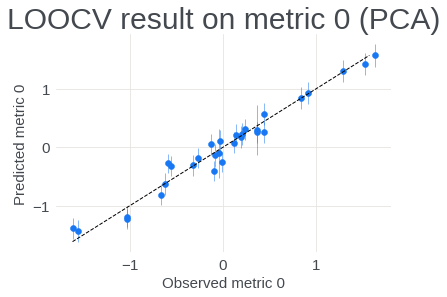

In [168]:
# plot leave-one-out cross validation results; error bars are 2 times the standard deviation

plot_metric_loocv(
    X_all=arms, Y_all=metric_observations, method="PCA", metric_dim=0, variance_explained_threshold=0.9, **tkwargs
)

## 2.2: Modeling fitting with Single-task GP

A natural baseline approach is to fit single-task GPs on each of the metrics. 

Here, we supply the ground-truth metric noise and use FixedNoiseGP() to fit the models. This is justified as in reality we observe the `SEM` columns that represent metric noise.

In [121]:
model_ST = initialize_model_ST(
    train_X=arms, train_Y=metric_observations, metric_noise_level=kwargs["metric_noise_level"]
)

In [122]:
metric_posterior_mean_ST, metric_posterior_variance_ST = get_posterior_predictions_ST(arms, model_ST, **tkwargs)

mean squared error = 0.015928214234758428


Text(0.5, 1.0, 'check model fit on metric dim 0 (single task, not inferring noise)')

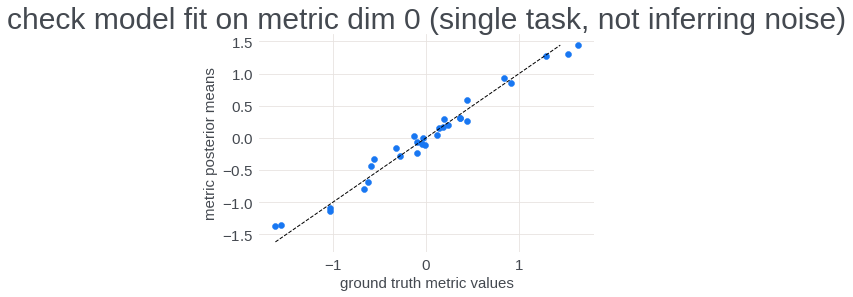

In [123]:
# check in-sample metric fit

check_dim = 0

scatter_plot_w_diag_line(metric_observations.detach().numpy(), metric_posterior_mean_ST.detach().numpy(), check_dim)
plt.xlabel("ground truth metric values")
plt.ylabel("metric posterior means")
plt.title("check model fit on metric dim {} (single task, not inferring noise)".format(check_dim))

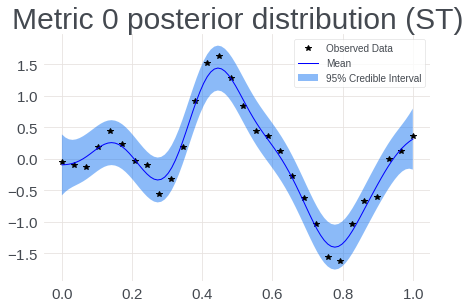

In [124]:
# plot posterior distribution of metric

plot_metric_posterior(
    test_x=torch.linspace(0, 1, 100),
    metric_dim=0,
    method="ST",
    model=model_ST,
    train_X=arms,
    train_Y=metric_observations,
    **tkwargs
)

Full input data shape torch.Size([30, 1]), output data shape torch.Size([30, 2])
loocv round 0


loocv round 5


loocv round 10


loocv round 15


loocv round 20


loocv round 25


mean squared error = 0.03811828257890671


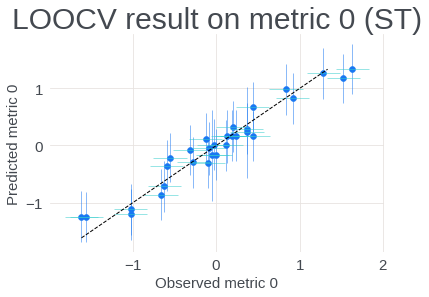

In [171]:
# plot leave-one-out results

plot_metric_loocv(X_all=arms, Y_all=metric_observations, method="ST", metric_dim=0, Y_var_all=0.1, **tkwargs)